## **GENERADOR DE GRÁFICAS DE DSC**
___

### CARACTERÍSTICAS
y obtención de datos asociados a transformaciones y transiciones 
___

ESTRUCTURA DE ARCHIVO:

Tipo de datos aceptados: ASCII, codificación: ANSI
- Las columnas a leer son 5:
    1. Indice (ºC)
    2. Tiempo (s)
    3. Temperatura del horno (ºC)
    4. Temperatura de la muestra (ºC)
    5. Termogravimetría (mg)
    6. Flujo de calor (mW)

ESTRUCTURA DE NOMBRE:
* Nombre de archivo de curva a procesar: "nombre_fijo.txt"
* Nombre de archivo de curva instrumental: "Blanco_nombre_fijo.txt"

EJEMPLO:
* Curva a procesar: "Cp_Aluminio.txt"
* Curva instrumental: "Blanco_Cp_Aluminio.txt"

DETALLES:
1. Para los nombres utilizar como separador solo:       "_"
2. Usar mismo tiempo de adquisición en curva original e instrumental
3. Se debe cambiar las rutas de acceso donde el script leerá las curvas a procesar (experimental) y curvas blanco (instrumental)
4. Asegurarse de solo colocar los archivos a procesar en las carpetas correspondientes
5. Las carpetas deben existir

COMENTARIOS:
* El script ha sido probado solo para datos de DSC modelo Labsys evo


###  Se importan las librerías necesarias
___

In [104]:
# Dependencies import
import os
import glob
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np
import pandas as pd
from pandas.errors import EmptyDataError
from scipy.signal import savgol_filter


%matplotlib inline
# to make this notebook's output stable across runs
np.random.seed(42)

###  Lectura de las carpetas de trabajo y sus archivos correspondientes
___

In [2]:
# os.walk is a generator and calling next will get the first result in the form of a 3-tuple (dirpath, dirnames, filenames)
# Thus the [1] index returns only the dirnames from that tuple. The '.' is for root path of the project.
#next(os.walk('.'))[1]

dir_name = '.'
root, dirs, files = next(os.walk(dir_name))
if '.ipynb_checkpoints' in dirs:
    dirs.remove('.ipynb_checkpoints')

In [3]:
# get the index of 'experimental'
pos_experimental = dirs.index('experimental')
pos_blanco = dirs.index('blanco')

In [4]:
# especificamos un patrón de archivo y lo pasamos como parámetro en la función glob
files_exp = glob.glob(dirs[pos_experimental]+'\*.txt', recursive=False)

In [5]:
# especificamos un patrón de archivo y lo pasamos como parámetro en la función glob
files_bl = glob.glob(dirs[pos_blanco]+'\*.txt', recursive=False)

In [6]:
# guardamos la lista de archivos en una variable temporal, también de tipo lista
tmp = files_exp
tmp2 = []
only_name_exp = []

for fnam in tmp:
    tmp2.append(fnam.rsplit('.', 1)[0])

for fnam in tmp2:
    only_name_exp.append(fnam.rsplit('\\', 1)[1])

In [7]:
# mostramos la lista de nombres
for list_files in only_name_exp:
    print(list_files)

10° Calentamiento 5 Kmin
10° Enfriamiento
1° Calentamiento 100 Kmin
1° Calentamiento descarte
1° Enfriamiento descarte
1° Enfriamiento
2° Calentamiento 50 Kmin
2° Enfriamiento
3° Calentamiento 20 Kmin
3° Enfriamiento
4° Calentamiento 10 Kmin
4° Enfriamiento
5° Calentamiento 5 Kmin
5° Enfriamiento
6° Calentamiento 100 Kmin
6° Enfriamiento
7° Calentamiento 50 Kmin
7° Enfriamiento
8° Calentamiento 20 Kmin
8° Enfriamiento
9° Calentamiento 10 Kmin
9° Enfriamiento


In [8]:
# guardamos la lista de archivos en una variable temporal, también de tipo lista
tmp = files_bl
tmp2 = []
only_name_bl = []

for fnam in tmp:
    tmp2.append(fnam.rsplit('.', 1)[0])

for fnam in tmp2:
    only_name_bl.append(fnam.rsplit('\\', 1)[1])

In [9]:
# mostramos la lista de nombres
for list_files in only_name_bl:
    print(list_files)

10° Calentamiento 5 Kmin
10° Enfriamiento
1° Calentamiento 100 Kmin
1° Calentamiento descarte
1° Enfriamiento descarte
1° Enfriamiento
2° Calentamiento 50 Kmin
2° Enfriamiento
3° Calentamiento 20 Kmin
3° Enfriamiento
4° Calentamiento 10 Kmin
4° Enfriamiento
5° Calentamiento 5 Kmin
5° Enfriamiento
6° Calentamiento 100 Kmin
6° Enfriamiento
7° Calentamiento 50 Kmin
7° Enfriamiento
8° Calentamiento 20 Kmin
8° Enfriamiento
9° Calentamiento 10 Kmin
9° Enfriamiento


###  De los archivos leídos, se quitan las columnas de datos que no se utilizaran
___

In [10]:
# Create an empty list to store your data frames
#### result containers
good_files_exp = []
bad_files_exp = []

#### iterate files in directory
for one_file in files_exp:
    print(f"Parsing: {one_file}")
    try:
        #### read csv file to pandas data frame
        df = pd.read_table(one_file, encoding='UTF-16LE', skiprows=14, delim_whitespace=True, header=None)
        #### drop the data we'll not use
        head = ["idx", "t", "Th", "Tm", "TG", "f"]
        df.columns = head
        df.drop('TG', inplace=True, axis=1)
        df.drop('idx', inplace=True, axis=1)
        df.drop('Th', inplace=True, axis=1)
        #### append the file name to a list of good files
        good_files_exp.append(df)
        # ...
    except EmptyDataError:
        print(f"No columns to parse from file {one_file}")
        bad_files_exp.append(one_file)
print('Done parsing.')

Parsing: experimental\10° Calentamiento 5 Kmin.txt
Parsing: experimental\10° Enfriamiento.txt
Parsing: experimental\1° Calentamiento 100 Kmin.txt
Parsing: experimental\1° Calentamiento descarte.txt
Parsing: experimental\1° Enfriamiento descarte.txt
Parsing: experimental\1° Enfriamiento.txt
Parsing: experimental\2° Calentamiento 50 Kmin.txt
Parsing: experimental\2° Enfriamiento.txt
Parsing: experimental\3° Calentamiento 20 Kmin.txt
Parsing: experimental\3° Enfriamiento.txt
Parsing: experimental\4° Calentamiento 10 Kmin.txt
Parsing: experimental\4° Enfriamiento.txt
Parsing: experimental\5° Calentamiento 5 Kmin.txt
Parsing: experimental\5° Enfriamiento.txt
Parsing: experimental\6° Calentamiento 100 Kmin.txt
Parsing: experimental\6° Enfriamiento.txt
Parsing: experimental\7° Calentamiento 50 Kmin.txt
Parsing: experimental\7° Enfriamiento.txt
Parsing: experimental\8° Calentamiento 20 Kmin.txt
Parsing: experimental\8° Enfriamiento.txt
Parsing: experimental\9° Calentamiento 10 Kmin.txt
Parsing

In [11]:
# mostramos los primeros 5 elementos de una tabla como ejemplo
print(good_files_exp[0].head(5))

     t          Tm         f
0  0.2  749.537817  8.200717
1  0.4  749.534754  8.200720
2  0.6  749.531139  8.201863
3  0.8  749.527256  8.202433
4  1.0  749.522247  8.202430


In [12]:
# Create an empty list to store your data frames
#### result containers
good_files_bl = []
bad_files_bl = []

#### iterate files in directory
for one_file in files_bl:
    print(f"Parsing: {one_file}")
    try:
        #### read csv file to pandas data frame
        df = pd.read_table(one_file, encoding='UTF-16LE', skiprows=14, delim_whitespace=True, header=None)
        #### drop the data we'll not use
        head = ["idx", "t", "Th", "Tm", "TG", "f"]
        df.columns = head
        df.drop('TG', inplace=True, axis=1)
        df.drop('idx', inplace=True, axis=1)
        df.drop('Th', inplace=True, axis=1)
        #### append the file name to a list of good files
        good_files_bl.append(df)
        # ...
    except EmptyDataError:
        print(f"No columns to parse from file {one_file}")
        bad_files_bl.append(one_file)
print('Done parsing.')

Parsing: blanco\10° Calentamiento 5 Kmin.txt
Parsing: blanco\10° Enfriamiento.txt
Parsing: blanco\1° Calentamiento 100 Kmin.txt
Parsing: blanco\1° Calentamiento descarte.txt
Parsing: blanco\1° Enfriamiento descarte.txt
Parsing: blanco\1° Enfriamiento.txt
Parsing: blanco\2° Calentamiento 50 Kmin.txt
Parsing: blanco\2° Enfriamiento.txt
Parsing: blanco\3° Calentamiento 20 Kmin.txt
Parsing: blanco\3° Enfriamiento.txt
Parsing: blanco\4° Calentamiento 10 Kmin.txt
Parsing: blanco\4° Enfriamiento.txt
Parsing: blanco\5° Calentamiento 5 Kmin.txt
Parsing: blanco\5° Enfriamiento.txt
Parsing: blanco\6° Calentamiento 100 Kmin.txt
Parsing: blanco\6° Enfriamiento.txt
Parsing: blanco\7° Calentamiento 50 Kmin.txt
Parsing: blanco\7° Enfriamiento.txt
Parsing: blanco\8° Calentamiento 20 Kmin.txt
Parsing: blanco\8° Enfriamiento.txt
Parsing: blanco\9° Calentamiento 10 Kmin.txt
Parsing: blanco\9° Enfriamiento.txt
Done parsing.


In [13]:
# mostramos los primeros 5 elementos de una tabla como ejemplo
print(good_files_bl[0].head(5))

     t          Tm          f
0  0.2  749.302029 -19.257379
1  0.4  749.302147 -19.268225
2  0.6  749.300642 -19.279641
3  0.8  749.301549 -19.288209
4  1.0  749.301884 -19.295062


###  Gráficas de flujo de calor en función del tiempo
___

In [14]:
# creamos variable para iterar
i = 0
for file_to_graph in good_files_exp:
    print(f"Graphing ΦQ (mW) vs t (s): {only_name_exp[i]} vs t")
    # Gráficos de flujo de calor vs temperatura de muestra
    fig1 = plt.figure(figsize=(12, 7.68))
    fig1.patch.set_facecolor("#6D9EC1")
    fig1.patch.set_alpha(0.15)

    ax = fig1.add_subplot()
    ax.patch.set_facecolor("#6D9EC1")

    ax.plot(file_to_graph.t, file_to_graph.f, linestyle='-', linewidth=0.5, color = "white", label="ΦQ")
    ax.set_ylabel('ΦQ (mW)')
    ax.set_xlabel('t (s)')
    ax.legend();
    
    fig1.savefig(f'graficos\{only_name_exp[i]}_vs_t.png')
    plt.close()
    i+=1
print('Done graphing.')

Graphing ΦQ (mW) vs t (s): 10° Calentamiento 5 Kmin vs t
Graphing ΦQ (mW) vs t (s): 10° Enfriamiento vs t
Graphing ΦQ (mW) vs t (s): 1° Calentamiento 100 Kmin vs t
Graphing ΦQ (mW) vs t (s): 1° Calentamiento descarte vs t
Graphing ΦQ (mW) vs t (s): 1° Enfriamiento descarte vs t
Graphing ΦQ (mW) vs t (s): 1° Enfriamiento vs t
Graphing ΦQ (mW) vs t (s): 2° Calentamiento 50 Kmin vs t
Graphing ΦQ (mW) vs t (s): 2° Enfriamiento vs t
Graphing ΦQ (mW) vs t (s): 3° Calentamiento 20 Kmin vs t
Graphing ΦQ (mW) vs t (s): 3° Enfriamiento vs t
Graphing ΦQ (mW) vs t (s): 4° Calentamiento 10 Kmin vs t
Graphing ΦQ (mW) vs t (s): 4° Enfriamiento vs t
Graphing ΦQ (mW) vs t (s): 5° Calentamiento 5 Kmin vs t
Graphing ΦQ (mW) vs t (s): 5° Enfriamiento vs t
Graphing ΦQ (mW) vs t (s): 6° Calentamiento 100 Kmin vs t
Graphing ΦQ (mW) vs t (s): 6° Enfriamiento vs t
Graphing ΦQ (mW) vs t (s): 7° Calentamiento 50 Kmin vs t
Graphing ΦQ (mW) vs t (s): 7° Enfriamiento vs t
Graphing ΦQ (mW) vs t (s): 8° Calentamiento

###  Gráficas de flujo de calor en función de la temperatura de la muestra
___

In [15]:
# creamos variable para iterar
i = len(good_files_exp)
for f in range(i):
    print(f"Graphing ΦQ (mW) vs T (°C): {only_name_bl[f]} vs Tm")

Graphing ΦQ (mW) vs T (°C): 10° Calentamiento 5 Kmin vs Tm
Graphing ΦQ (mW) vs T (°C): 10° Enfriamiento vs Tm
Graphing ΦQ (mW) vs T (°C): 1° Calentamiento 100 Kmin vs Tm
Graphing ΦQ (mW) vs T (°C): 1° Calentamiento descarte vs Tm
Graphing ΦQ (mW) vs T (°C): 1° Enfriamiento descarte vs Tm
Graphing ΦQ (mW) vs T (°C): 1° Enfriamiento vs Tm
Graphing ΦQ (mW) vs T (°C): 2° Calentamiento 50 Kmin vs Tm
Graphing ΦQ (mW) vs T (°C): 2° Enfriamiento vs Tm
Graphing ΦQ (mW) vs T (°C): 3° Calentamiento 20 Kmin vs Tm
Graphing ΦQ (mW) vs T (°C): 3° Enfriamiento vs Tm
Graphing ΦQ (mW) vs T (°C): 4° Calentamiento 10 Kmin vs Tm
Graphing ΦQ (mW) vs T (°C): 4° Enfriamiento vs Tm
Graphing ΦQ (mW) vs T (°C): 5° Calentamiento 5 Kmin vs Tm
Graphing ΦQ (mW) vs T (°C): 5° Enfriamiento vs Tm
Graphing ΦQ (mW) vs T (°C): 6° Calentamiento 100 Kmin vs Tm
Graphing ΦQ (mW) vs T (°C): 6° Enfriamiento vs Tm
Graphing ΦQ (mW) vs T (°C): 7° Calentamiento 50 Kmin vs Tm
Graphing ΦQ (mW) vs T (°C): 7° Enfriamiento vs Tm
Graphin

In [16]:
# creamos variable para iterar
i = 0
for file_to_graph in good_files_exp:
    print(f"Graphing ΦQ (mW) vs T (°C): {only_name_bl[i]} vs Tm")
    # Gráficos de flujo de calor vs temperatura de muestra
    fig2 = plt.figure(figsize=(12, 7.68))
    fig2.patch.set_facecolor("#6D9EC1")
    fig2.patch.set_alpha(0.15)

    ax = fig2.add_subplot()
    ax.patch.set_facecolor("#6D9EC1")

    ax.plot(file_to_graph.Tm, file_to_graph.f, linestyle='-', linewidth=0.5, color = "white", label="ΦQ")
    ax.set_ylabel('ΦQ (mW)')
    ax.set_xlabel('T (°C)')
    ax.legend();
    
    fig2.savefig(f'graficos\{only_name_bl[i]} vs Tm.png')
    plt.close()
    i+=1
print('Done graphing.')

Graphing ΦQ (mW) vs T (°C): 10° Calentamiento 5 Kmin vs Tm
Graphing ΦQ (mW) vs T (°C): 10° Enfriamiento vs Tm
Graphing ΦQ (mW) vs T (°C): 1° Calentamiento 100 Kmin vs Tm
Graphing ΦQ (mW) vs T (°C): 1° Calentamiento descarte vs Tm
Graphing ΦQ (mW) vs T (°C): 1° Enfriamiento descarte vs Tm
Graphing ΦQ (mW) vs T (°C): 1° Enfriamiento vs Tm
Graphing ΦQ (mW) vs T (°C): 2° Calentamiento 50 Kmin vs Tm
Graphing ΦQ (mW) vs T (°C): 2° Enfriamiento vs Tm
Graphing ΦQ (mW) vs T (°C): 3° Calentamiento 20 Kmin vs Tm
Graphing ΦQ (mW) vs T (°C): 3° Enfriamiento vs Tm
Graphing ΦQ (mW) vs T (°C): 4° Calentamiento 10 Kmin vs Tm
Graphing ΦQ (mW) vs T (°C): 4° Enfriamiento vs Tm
Graphing ΦQ (mW) vs T (°C): 5° Calentamiento 5 Kmin vs Tm
Graphing ΦQ (mW) vs T (°C): 5° Enfriamiento vs Tm
Graphing ΦQ (mW) vs T (°C): 6° Calentamiento 100 Kmin vs Tm
Graphing ΦQ (mW) vs T (°C): 6° Enfriamiento vs Tm
Graphing ΦQ (mW) vs T (°C): 7° Calentamiento 50 Kmin vs Tm
Graphing ΦQ (mW) vs T (°C): 7° Enfriamiento vs Tm
Graphin

###  Se sustrae el flujo de calor, de los experimentos "blanco" a los "experimental"
___

In [17]:
# Create an empty list to store your data drames
#### result containers
files_sub = []

# creamos variable para iterar
length = len(good_files_exp)
for f in range(length):
    files_sub.append(good_files_exp[f].f - good_files_bl[f].f)

In [18]:
for f in range(length):
    print(f"Graphing ΦQ (mW) vs T (°C): {only_name_bl[f]} vs Tm")
    # Gráficos de flujo de calor vs temperatura de muestra
    fig2 = plt.figure(figsize=(12, 7.68))
    fig2.patch.set_facecolor("#6D9EC1")
    fig2.patch.set_alpha(0.15)

    ax = fig2.add_subplot()
    ax.patch.set_facecolor("#6D9EC1")

    ax.plot(good_files_exp[f].Tm, files_sub[f], linestyle='-', linewidth=0.5, color = "white", label="ΦQ")
    ax.set_ylabel('ΦQ (mW)')
    ax.set_xlabel('T (°C)')
    ax.legend();
    
    fig2.savefig(f'graficos\{only_name_bl[f]} subst vs Tm.png')
    plt.close()
    i+=1
print('Done graphing.')

Graphing ΦQ (mW) vs T (°C): 10° Calentamiento 5 Kmin vs Tm
Graphing ΦQ (mW) vs T (°C): 10° Enfriamiento vs Tm
Graphing ΦQ (mW) vs T (°C): 1° Calentamiento 100 Kmin vs Tm
Graphing ΦQ (mW) vs T (°C): 1° Calentamiento descarte vs Tm
Graphing ΦQ (mW) vs T (°C): 1° Enfriamiento descarte vs Tm
Graphing ΦQ (mW) vs T (°C): 1° Enfriamiento vs Tm
Graphing ΦQ (mW) vs T (°C): 2° Calentamiento 50 Kmin vs Tm
Graphing ΦQ (mW) vs T (°C): 2° Enfriamiento vs Tm
Graphing ΦQ (mW) vs T (°C): 3° Calentamiento 20 Kmin vs Tm
Graphing ΦQ (mW) vs T (°C): 3° Enfriamiento vs Tm
Graphing ΦQ (mW) vs T (°C): 4° Calentamiento 10 Kmin vs Tm
Graphing ΦQ (mW) vs T (°C): 4° Enfriamiento vs Tm
Graphing ΦQ (mW) vs T (°C): 5° Calentamiento 5 Kmin vs Tm
Graphing ΦQ (mW) vs T (°C): 5° Enfriamiento vs Tm
Graphing ΦQ (mW) vs T (°C): 6° Calentamiento 100 Kmin vs Tm
Graphing ΦQ (mW) vs T (°C): 6° Enfriamiento vs Tm
Graphing ΦQ (mW) vs T (°C): 7° Calentamiento 50 Kmin vs Tm
Graphing ΦQ (mW) vs T (°C): 7° Enfriamiento vs Tm
Graphin

###  Cálculo de derivada del flujo calórico en función del tiempo
___

Método: Automatic Derivative / algorithmic differentiation / computational differentiation / auto-differentiation

In [19]:
import autograd.numpy as np   # Thinly-wrapped version of Numpy
from autograd import elementwise_grad

# convert to NumPy array
Tm = good_files_exp[12].Tm.to_numpy()
Y = files_sub[12].to_numpy()

#diff_Y = grad(Y)

In [20]:
def function(x):                 # Define a function
    y = Y/x
    return y
grad_function = elementwise_grad(function)
#grad_function(1.0)

In [21]:
diff_Y = grad_function(Tm)

Graphing diff of ΦQ (mW) vs T (°C): 5° Calentamiento 5 Kmin vs Tm


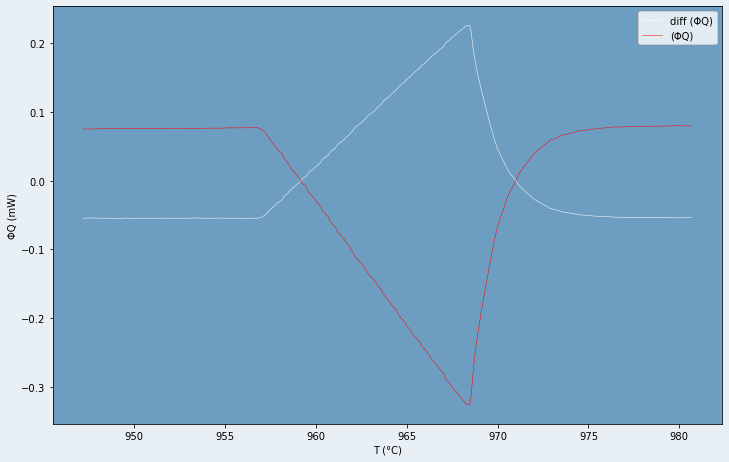

In [22]:
print(f"Graphing diff of ΦQ (mW) vs T (°C): {only_name_bl[12]} vs Tm")
# Gráficos de flujo de calor vs temperatura de muestra
fig2 = plt.figure(figsize=(12, 7.68))
fig2.patch.set_facecolor("#6D9EC1")
fig2.patch.set_alpha(0.15)

ax = fig2.add_subplot()
ax.patch.set_facecolor("#6D9EC1")

ax.plot(Tm[12000:14000], diff_Y[12000:14000]*1000, linestyle='-', linewidth=0.5, color = "white", label="diff (ΦQ)")
ax.plot(Tm[12000:14000], files_sub[12][12000:14000]/650, linestyle='-', linewidth=0.5, color = "red", label="(ΦQ)")
ax.set_ylabel('ΦQ (mW)')
ax.set_xlabel('T (°C)')
ax.legend();

###  Cálculo de derivada del flujo calórico en función del tiempo
___

Método: Gradient

Savitzky-Golay filter

In [149]:
# convert to NumPy array
Tm = good_files_exp[12].Tm.to_numpy()
Y = files_sub[12].to_numpy()
X = Tm


# Savitzky-Golay filter: window size (savgol_window=), polynomial order (pol_order=)
savgol_window = 100
pol_order = 7
# smooth of Y
Y_smooth = savgol_filter(Y, savgol_window, pol_order)

# first derivative
dY_dx = np.gradient(Y_smooth, X)
# smooth first derivative
dY_dx_smooth = savgol_filter(dY_dx, savgol_window, pol_grad)

# second derivative
ddY_dx2 = np.gradient(dY_dx, X)
# smooth second derivative
ddY_dx2_smooth = savgol_filter(ddY_dx2, savgol_window, pol_grad)
ddY_dx2_smooth2 = savgol_filter(ddY_dx2_smooth, 50, 3)
#ddY_dx2_smooth3 = savgol_filter(ddY_dx2_smooth2, 50, 5)

# third derivative
ddY_dx3 = np.gradient(ddY_dx2, X)
# smooth third derivative
ddY_dx3_smooth = savgol_filter(ddY_dx3, savgol_window, pol_grad)

Graphing diff of ΦQ (mW) vs T (°C): 5° Calentamiento 5 Kmin vs Tm


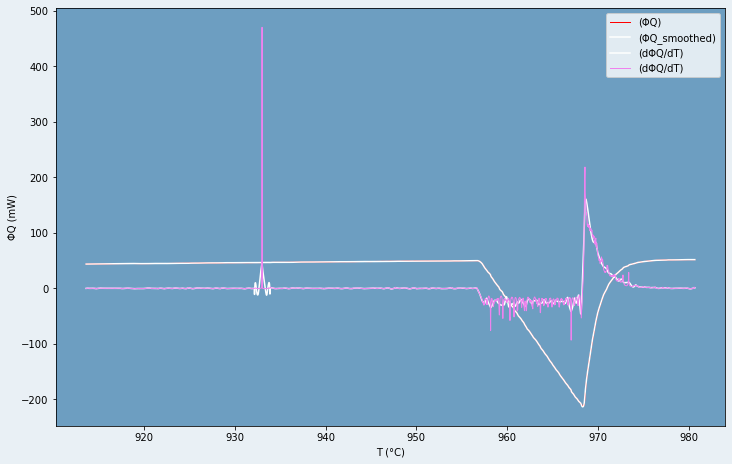

In [150]:
print(f"Graphing diff of ΦQ (mW) vs T (°C): {only_name_bl[12]} vs Tm")
# Gráficos de flujo de calor vs temperatura de muestra
fig2 = plt.figure(figsize=(12, 7.68))
fig2.patch.set_facecolor("#6D9EC1")
fig2.patch.set_alpha(0.15)

ax1 = fig2.add_subplot()
ax1.patch.set_facecolor("#6D9EC1")

ax1.plot(X[10000:14000], files_sub[12][10000:14000], linestyle='-', linewidth=1.0, color = "red", label="(ΦQ)")
ax1.plot(X[10000:14000], Y_smooth[10000:14000], linestyle='-', linewidth=1.5, color = "white", label="(ΦQ_smoothed)")
ax1.plot(X[10000:14000], dY_dx_smooth[10000:14000], linestyle='-', linewidth=1.5, color = "white", label="(dΦQ/dT)")
ax1.plot(X[10000:14000], dY_dx[10000:14000], linestyle='-', linewidth=1.0, color = "violet", label="(dΦQ/dT)")
#ax1.plot(X[10000:14000], ddY_dx2_smooth2[10000:14000], linestyle='-', linewidth=1.0, color = "black", label="(dΦQ/dT)")


ax1.set_ylabel('ΦQ (mW)')
ax1.set_xlabel('T (°C)')
ax1.legend();

Hampel Filter

In [209]:
from hampel import hampel

Tm = good_files_exp[12].Tm.to_numpy()
Y = files_sub[12]
X = Tm


# Hampel filter: window size (window_size=), order (order=)
window_size = 5
order = 3

# smooth of Y
ts_imputation = hampel(Y, window_size, order, imputation=True)

# first derivative
dY_dx = pd.Series(np.gradient(ts_imputation, X))
# smooth first derivative


C:\Users\Pablo\anaconda3\envs\dsc-heat\lib\site-packages\numpy\lib\function_base.py:1239: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
C:\Users\Pablo\anaconda3\envs\dsc-heat\lib\site-packages\numpy\lib\function_base.py:1240: RuntimeWarning: divide by zero encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
C:\Users\Pablo\anaconda3\envs\dsc-heat\lib\site-packages\numpy\lib\function_base.py:1241: RuntimeWarning: divide by zero encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
C:\Users\Pablo\anaconda3\envs\dsc-heat\lib\site-packages\numpy\lib\function_base.py:1247: RuntimeWarning: invalid value encountered in add
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]


Graphing diff of ΦQ (mW) vs T (°C): 5° Calentamiento 5 Kmin vs Tm


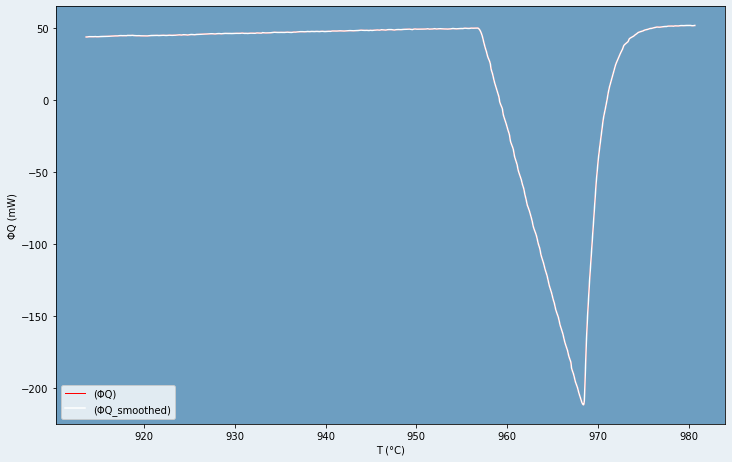

In [215]:
print(f"Graphing diff of ΦQ (mW) vs T (°C): {only_name_bl[12]} vs Tm")
# Gráficos de flujo de calor vs temperatura de muestra
fig2 = plt.figure(figsize=(12, 7.68))
fig2.patch.set_facecolor("#6D9EC1")
fig2.patch.set_alpha(0.15)

ax1 = fig2.add_subplot()
ax1.patch.set_facecolor("#6D9EC1")

ax1.plot(X[10000:14000], files_sub[12][10000:14000], linestyle='-', linewidth=1.0, color = "red", label="(ΦQ)")
ax1.plot(X[10000:14000], ts_imputation[10000:14000], linestyle='-', linewidth=1.5, color = "white", label="(ΦQ_smoothed)")


ax1.set_ylabel('ΦQ (mW)')
ax1.set_xlabel('T (°C)')
ax1.legend();

In [210]:
# Hampel filter: window size (window_size=), order (order=)
window_size = 50
order = 3

dY_dx_smooth = hampel(dY_dx, window_size, order, imputation=True)
ts_imputation2 = pd.Series(savgol_filter(dY_dx_smooth, savgol_window, pol_grad))

Graphing diff of ΦQ (mW) vs T (°C): 5° Calentamiento 5 Kmin vs Tm


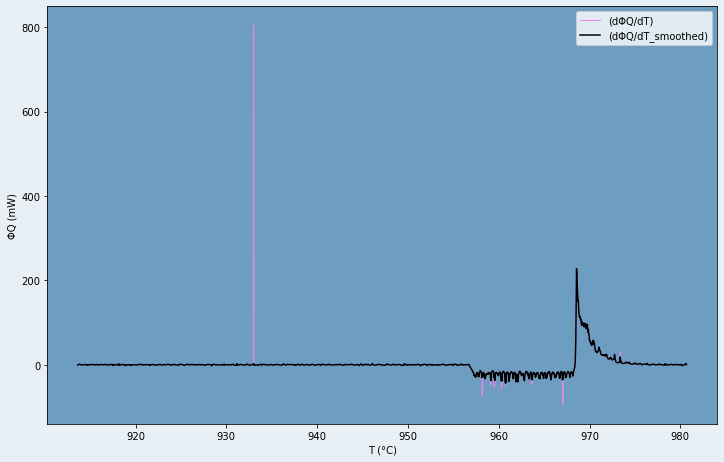

In [216]:
print(f"Graphing diff of ΦQ (mW) vs T (°C): {only_name_bl[12]} vs Tm")
# Gráficos de flujo de calor vs temperatura de muestra
fig2 = plt.figure(figsize=(12, 7.68))
fig2.patch.set_facecolor("#6D9EC1")
fig2.patch.set_alpha(0.15)

ax1 = fig2.add_subplot()
ax1.patch.set_facecolor("#6D9EC1")

ax1.plot(X[10000:14000], dY_dx[10000:14000], linestyle='-', linewidth=1.0, color = "violet", label="(dΦQ/dT)")
ax1.plot(X[10000:14000], dY_dx_smooth[10000:14000], linestyle='-', linewidth=1.5, color = "black", label="(dΦQ/dT_smoothed)")


ax1.set_ylabel('ΦQ (mW)')
ax1.set_xlabel('T (°C)')
ax1.legend();

Simple Moving Average

In [271]:
arr = [1, 2, 3, 7, 9]
window_size = 50

# Convert array of integers to pandas series
numbers_series = pd.Series(dY_dx_smooth)

# Get the window of series
# of observations of specified window size
windows = numbers_series.rolling(window_size)

# Create a series of moving
# averages of each window
moving_averages2 = windows.mean()

# Convert pandas series back to list
moving_averages_list =  pd.Series(moving_averages2.tolist())

In [278]:
# Hampel filter: window size (window_size=), order (order=)
window_size = 50
order = 3

final_list_smooth = hampel(moving_averages_list, window_size, order, imputation=True)

In [279]:
from scipy import ndimage

result = ndimage.median_filter(final_list_smooth, size=20)

Graphing diff of ΦQ (mW) vs T (°C): 5° Calentamiento 5 Kmin vs Tm


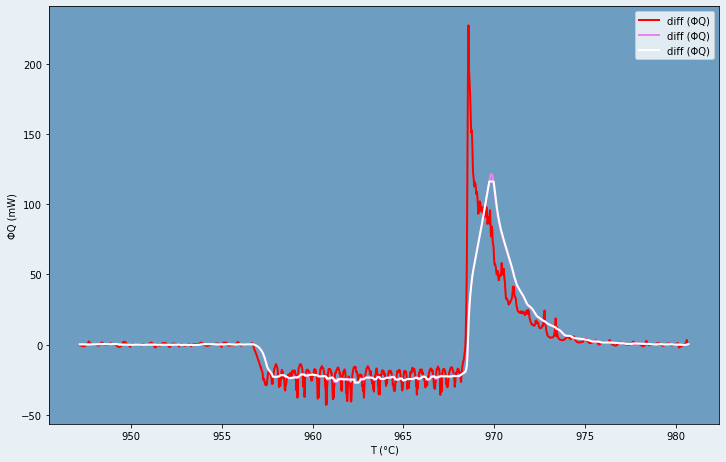

In [286]:
print(f"Graphing diff of ΦQ (mW) vs T (°C): {only_name_bl[12]} vs Tm")
# Gráficos de flujo de calor vs temperatura de muestra
fig2 = plt.figure(figsize=(12, 7.68))
fig2.patch.set_facecolor("#6D9EC1")
fig2.patch.set_alpha(0.15)

ax1 = fig2.add_subplot()
ax1.patch.set_facecolor("#6D9EC1")

ax1.plot(X[12000:14000], dY_dx_smooth[12000:14000], linestyle='-', linewidth=2, color = "red", label="diff (ΦQ)")
ax1.plot(X[12000:14000], final_list_smooth[12000:14000], linestyle='-', linewidth=2, color = "violet", label="diff (ΦQ)")
ax1.plot(X[12000:14000], result[12000:14000], linestyle='-', linewidth=2, color = "white", label="diff (ΦQ)")

ax1.set_ylabel('ΦQ (mW)')
ax1.set_xlabel('T (°C)')
ax1.legend();

# Correr hacia la izquierda después del SMA

Simple Moving Average

In [151]:
window_size = 200

i = 0
# Initialize an empty list to store moving averages
moving_averages = []
  
# Loop through the array t o
#consider every window of size 3
while i < len(dY_dx_smooth) - window_size + 1:
  
    # Calculate the average of current window
    window_average = round(np.sum(dY_dx_smooth[i:i+window_size]) / window_size, 2)
      
    # Store the average of current
    # window in moving average list
    moving_averages.append(window_average)
      
    # Shift window to right by one position
    i += 1


In [155]:
arr = [1, 2, 3, 7, 9]
window_size = 200

# Convert array of integers to pandas series
numbers_series = pd.Series(dY_dx_smooth)

# Get the window of series
# of observations of specified window size
windows = numbers_series.rolling(window_size)

# Create a series of moving
# averages of each window
moving_averages2 = windows.mean()

# Convert pandas series back to list
moving_averages_list = moving_averages2.tolist()

# Remove null entries from the list
final_list = moving_averages_list[window_size - 1:]

Graphing diff of ΦQ (mW) vs T (°C): 5° Calentamiento 5 Kmin vs Tm


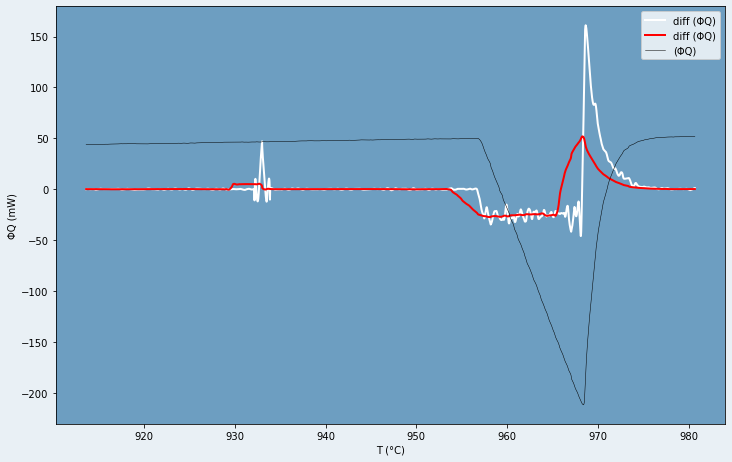

In [157]:
print(f"Graphing diff of ΦQ (mW) vs T (°C): {only_name_bl[12]} vs Tm")
# Gráficos de flujo de calor vs temperatura de muestra
fig2 = plt.figure(figsize=(12, 7.68))
fig2.patch.set_facecolor("#6D9EC1")
fig2.patch.set_alpha(0.15)

ax1 = fig2.add_subplot()
ax1.patch.set_facecolor("#6D9EC1")

ax1.plot(X[10000:14000], dY_dx_smooth[10000:14000], linestyle='-', linewidth=2, color = "white", label="diff (ΦQ)")
ax1.plot(X[10000:14000], moving_averages[10000:14000], linestyle='-', linewidth=2, color = "red", label="diff (ΦQ)")
#ax1.plot(X[12400:14000], final_list[12400:14000], linestyle='-', linewidth=2, color = "orange", label="diff (ΦQ)")
#ax1.plot(X[12400:14000], ma_ddY_dx2_smooth[12400:14000], linestyle='-', linewidth=0.5, color = "orange", label="diff2 (ΦQ)")
ax1.plot(X[10000:14000], files_sub[12][10000:14000], linestyle='-', linewidth=0.5, color = "black", label="(ΦQ)")
#ax1.plot(X[12400:14000], ma_ddY_dx3_smooth[12400:14000], linestyle='-', linewidth=0.1, color = "black", label="diff3 (ΦQ)")

ax1.set_ylabel('ΦQ (mW)')
ax1.set_xlabel('T (°C)')
ax1.legend();

In [159]:
arr = [1, 2, 3, 7, 9]
window_size = 200

# Convert array of integers to pandas series
numbers_series = pd.Series(ddY_dx2_smooth)

# Get the window of series
# of observations of specified window size
windows = numbers_series.rolling(window_size)

# Create a series of moving
# averages of each window
moving_averages3 = windows.mean()

# Convert pandas series back to list
moving_averages_list = moving_averages3.tolist()

# Remove null entries from the list
final_list2 = moving_averages_list[window_size - 1:]

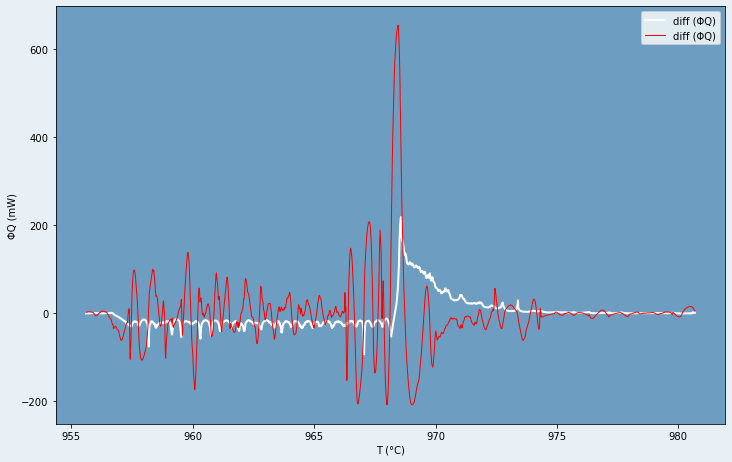

In [163]:
# Gráficos de flujo de calor vs temperatura de muestra
fig2 = plt.figure(figsize=(12, 7.68))
fig2.patch.set_facecolor("#6D9EC1")
fig2.patch.set_alpha(0.15)

ax1 = fig2.add_subplot()
ax1.patch.set_facecolor("#6D9EC1")

ax1.plot(X[12500:14000], dY_dx[12500:14000], linestyle='-', linewidth=2, color = "white", label="diff (ΦQ)")
ax1.plot(X[12500:14000], ddY_dx2_smooth[12500:14000], linestyle='-', linewidth=1, color = "red", label="diff (ΦQ)")

ax1.set_ylabel('ΦQ (mW)')
ax1.set_xlabel('T (°C)')
ax1.legend();

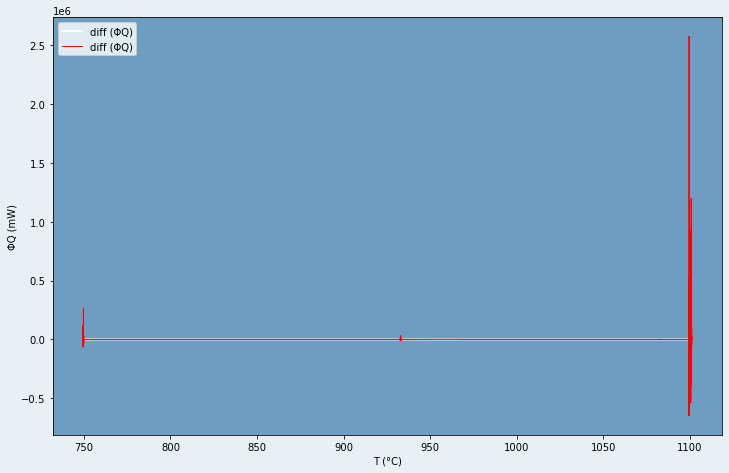

In [28]:
# Gráficos de flujo de calor vs temperatura de muestra
fig2 = plt.figure(figsize=(12, 7.68))
fig2.patch.set_facecolor("#6D9EC1")
fig2.patch.set_alpha(0.15)

ax1 = fig2.add_subplot()
ax1.patch.set_facecolor("#6D9EC1")

ax1.plot(X, dY_dx, linestyle='-', linewidth=2, color = "white", label="diff (ΦQ)")
ax1.plot(X, ddY_dx2_smooth, linestyle='-', linewidth=1, color = "red", label="diff (ΦQ)")

ax1.set_ylabel('ΦQ (mW)')
ax1.set_xlabel('T (°C)')
ax1.legend();

In [29]:
max(dY_dx)

2145.696561046876